In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [ ]:
def instantaneousCorrelation(deltat):
    return np.exp(-beta*np.abs(deltat))

def volatilityFun2(t,Kj,tj):
    if (t > tj):
        return 0
    else:
        sigma = Kj*((a + b*(tj - t))*np.exp(-c*(tj - t)) + d)
        return sigma

def volatilityFun(t,Kj,tj):
    idx = np.argwhere(t == tj)[0][0]
    sigma = Kj*((a + b*(tj - t))*np.exp(-c*(tj - t)) + d)
    sigma[idx+1:] = np.zeros(sigma[idx+1:].shape)
    return sigma

def computeCovarianceForwardRatePair(timesArray,t1,t2, i,j):
    t = timesArray

    tmin = min(t[i], t[j])

    if(t1 >= tmin):
        return 0
    else:

        dt = t[i] - t[j]
        rho_ij = instantaneousCorrelation(dt)

        f1 = np.exp(-c*(t[i]+t[j]))
        f2 = np.exp(2*c*t2)-np.exp(2*c*t1)
        f3 = t2*np.exp(2*c*t2) - t1*np.exp(2*c*t1) - (1/(2*c))*f2
        term11 = (a*a/(2*c))*f1*f2
        term12 = a*b*f1*(1/(2*c))*(t[i]*f2 - f3)
        term13 = a*b*f1*(1/(2*c))*(t[j]*f2 - f3)
        term141 = b*b*f1*(t[i]*t[j]/(2*c))*f2
        term142 = -b*b*f1*t[i]*(1/(2*c))*f3
        term143 = -b*b*f1*t[j]*(1/(2*c))*f3
        term144 = b*b*f1*(1/(2*c))*(t2**2*np.exp(2*c*t2) - t1**2*np.exp(2*c*t1) - (1/c)*f3)
        term14 = term141 + term142 + term143 + term144

        term1 = term11 + term12 + term13 + term14

        f4 = (1/c)*(np.exp(c*t2)-np.exp(c*t1))

        term21 = a*d*np.exp(-c*t[i])*f4
        term22 = b*d*np.exp(-c*t[i])*t[i]*f4
        term23 = -b*d*np.exp(-c*t[i])*(1/c)*(t2*np.exp(c*t2) - t1*np.exp(c*t1) - (1/c)*(np.exp(c*t2)-np.exp(c*t1)))

        term2 = term21 + term22 + term23

        term31 = a*d*np.exp(-c*t[j])*f4
        term32 = b*d*np.exp(-c*t[j])*t[j]*f4
        term33 = -b*d*np.exp(-c*t[j])*(1/c)*(t2*np.exp(c*t2) - t1*np.exp(c*t1) - (1/c)*(np.exp(c*t2)-np.exp(c*t1)))

        term3 = term31 + term32 + term33

        term4 = d*d*(t2-t1)

        # Calculate covariance
        return rho_ij*Kj[i]*Kj[j]*(term1 + term2 + term3 + term4)

def computeForwardRateCovarianceMatrix(timesArray,t1,t2):

    """
    t1 < t2
    """
    t = timesArray
    cov = np.zeros((N-1,N-1))

    for i in range(N-1):
        for j in range(N-1):

            cov[i][j] = computeCovarianceForwardRatePair(timesArray,t1,t2, i,j)

    return cov

def computeForwardRateCorrelationMatrix(timesArray,t1,t2):

    """
    t1 < t2
    """
    t = timesArray
    corr = np.zeros((N-1,N-1))

    for i in range(N-1):
        sigirms =  np.sqrt(computeCovarianceForwardRatePair(timesArray,t1,t2, i,i))
        for j in range(N-1):
            sigjrms = np.sqrt(computeCovarianceForwardRatePair(timesArray,t1,t2, j,j))
            if(sigirms*sigjrms < 1e-7):
                corr[i][j] = 0
            else:
                corr[i][j] = computeCovarianceForwardRatePair(timesArray,t1,t2, i,j)/(sigirms*sigjrms)

    return corr

def computeNumericallyForwardRateCovarianceMatrix(t1, t2,grid_density = 1e3):

    _n = grid_density
    dt = (t2-t1)/(_n-1)
    cov = np.zeros((N-1,N-1))
    for i in range(N-1):
        for j in range(N-1):

            rho_ij = instantaneousCorrelation(timesArray[i] - timesArray[j])
            sigma1 = lambda x : volatilityFun(x, Kj[i], timesArray[i])
            sigma2 = lambda x : volatilityFun(x, Kj[j], timesArray[j])

            # Calculate covariance
            _sum = 0
            for k in range(int(_n)):
                _sum += sigma1(t1 + dt*k)*sigma2(t1+ dt*k)

            cov[i][j] = rho_ij*_sum*dt
    return cov

In [ ]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMput(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMcaplet(f0, K, T2, P2, T1, sigma):
    """
    f0: Stock price at time t
    K : strike
    T2: expiry date
    T1: start date of forward rate agreement
    sigma: volatility
    Ps : Discount curve
    """
    Q = BSMcall(St= f0, K = K, T = T1, t = 0, r = 0, q = 0, sigma = sigma)

    return Q*(T2-T1)*P2

def OneDGBMPathGenerator(d,S0,T,r,q,sigma):
    """
    d : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    """
    return S0*np.exp((r-q-sigma**2/2)*np.repeat(np.array([T]),d) + sigma*np.sqrt(T)*np.random.normal(size=(d)))

def GBMPathGenerator(n,d,S0,T,r,q,sigma):
        """
        n : dimensionality / number of increments
        d : number of paths
        S0: initial stock price
        T : maturity
        r : risk free interest rate
        q : divident rate
        sigma : stock volatility
        """
        times = np.linspace(0., T, n)
        dt = times[1] - times[0]
        timesArray = np.array([times for i in range(d)]).transpose()
        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((n, d))
        dB[1:, :] = np.sqrt(dt) * np.random.normal(size=(n-1, d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*B)
        return S


In [ ]:
from abc import abstractmethod
class BGMProduct:
    def __init__():
        pass

    @abstractmethod
    def getUnderlyingTimes():
        pass

    @abstractmethod
    def getEvolutionTimes():
        pass

    @abstractmethod
    def reset():
        pass

    @abstractmethod
    def doNextStep():
        pass


In [ ]:
class BGMEngine:
    def __init__(self,
                 Npaths,
                 underlyingTimes,
                 randomNumberGenerator,
                 subStepping,
                 initialForwardRates,
                 numeraireIndex,
                 ):
        self.Npaths = Npaths

        self.underlyingTimes = underlyingTimes
        self.subStepping = subStepping
        self.getFullEvolutionTimes()
        self.evolutionIndices = self.getEvolutionIndices()

        self.rng = randomNumberGenerator

        self.initialForwardRates = np.tile(initialForwardRates,(Npaths,1)).transpose()

        self.numeraireIndex = numeraireIndex

        self.precomputeUsefulQuantities()
        self.initialDrifts = self.computeAllDrifts(self.initialForwardRates, 0)

    def getFullEvolutionTimes(self):
        """
        Based on the substepping parameter, this function computes all the times
        for which the engine simulates the evolution of the product.

        If substepping is set to 2, then the engine looks at the spacing of evolution times
        of the product and doubles the density of evolution times.

        This algorithm only works with equally spaced evolution points!
        """

        dt = self.underlyingTimes[1] - self.underlyingTimes[0]

        self.edt = dt/self.subStepping # Substepping dt

        self.evolutionTimes = np.linspace(0, self.underlyingTimes[-1], int(self.underlyingTimes[-1]/self.edt)+1)

        self.evolutionTimeSteps = np.size(self.evolutionTimes)

        # Find the evolution time index of the earliest maturity of a forward rate
        self.firstIndex = np.argwhere(self.evolutionTimes==self.underlyingTimes[0])[0][0]

    def precomputeUsefulQuantities(self):
        """
        This function computes the correlation matrix between any 2 forward rates between any 2 dates
        The correlation matrix is necessary to produce correlated forward rate paths

        Similarly, this function computes the root mean square volatility between any 2 evolution points
        needed for proper simulation of forward rate paths
        """

        self.corrMatrices = []
        self.pseudoRootCorr = []
        self.rmsSigma = np.zeros((NFR, self.evolutionTimeSteps))

        for i in range(self.evolutionTimeSteps-1):

            et0 = self.evolutionTimes[i]
            et1 = self.evolutionTimes[i+1]

            corr = computeForwardRateCorrelationMatrix(timesArray,et0,et1)

            _eig = np.linalg.eig(corr)
            P = _eig.eigenvectors
            D_half = np.diag(np.sqrt(_eig.eigenvalues))
            A = P@D_half

            self.corrMatrices.append(corr)
            self.pseudoRootCorr.append(A)

        # Compute root mean square volatility between 2 evolution points
        for j in range(NFR):
            self.rmsSigma[j][:-1] = np.sqrt(.5*(volatilityFun(self.evolutionTimes[1:], Kj[j], timesArray[j])**2+volatilityFun(self.evolutionTimes[:-1], Kj[j], timesArray[j])**2))

    def getEvolutionIndices(self):

        return [self.firstIndex + self.subStepping*i for i in range(len(self.underlyingTimes))]

    def computeDriftsLong(self, forwardRates, timeIndex):
        """
        This function computes the drifts of the forward rates which expire before the maturity of the bond which is taken as the numeraire
        The bond of the numeraire is said to be too long for the forward rate
        """

        f = forwardRates
        l = self.numeraireIndex

        longMus = np.zeros((l,self.Npaths))

        for r in range(2,l+1):
            for j in range(1,r):

                tau = (self.underlyingTimes[l-r+j+1]-self.underlyingTimes[l-r+j])

                deltat = (self.underlyingTimes[l-r+j]-self.underlyingTimes[l-r])

                longMus[l-r,:] -= ((f[l-r+j,:]*tau)/(1+f[l-r+j,:]*tau))*instantaneousCorrelation(deltat)*self.rmsSigma[l-r][timeIndex]*self.rmsSigma[l-r+j][timeIndex]


        return longMus

    def computeDriftsShort(self, forwardRates, timeIndex):
        """
        This function computes the drifts of the forward rates which expire after the maturity of the bond which is taken as the numeraire
        The bond of the numeraire is said to be too short for the forward rate
        """

        f = forwardRates
        l = self.numeraireIndex

        shortMus = np.zeros((NFR,self.Npaths))

        for r in range(0,NFR-l):
            for j in range(0,r+1):

                tau = (self.underlyingTimes[l+j+1]-self.underlyingTimes[l+j])

                deltat = (self.underlyingTimes[l+r]-self.underlyingTimes[l+j])

                shortMus[l+r,:] += ((f[l+j,:]*tau)/(1+f[l+j,:]*tau))*(
                    instantaneousCorrelation(deltat)*self.rmsSigma[l+r][timeIndex]*self.rmsSigma[l+j][timeIndex])

        return shortMus[l:,:]

    def computeAllDrifts(self,forwardRates, timeIndex):

        l = self.numeraireIndex

        mu = np.zeros((NFR, Npaths))
        mu[:l,:] = self.computeDriftsLong(forwardRates,timeIndex)
        mu[l:,:] = self.computeDriftsShort(forwardRates,timeIndex)

        return mu

    def evolveForwardRates(self, drifts, inputForwardRates, timeIndex, X):

        """
        The forward rates are evolved using the log normal formula
        """

        _sigma = np.tile(self.rmsSigma[:,timeIndex], (Npaths, 1)).transpose()

        outputForwardRates = inputForwardRates*np.exp((drifts-.5*_sigma**2)*self.edt + _sigma*np.sqrt(self.edt)*X )

        return outputForwardRates


    def run(self):
        # Forward rates indices are First the Forward Rate Index, The Path Index then the Evolution Time Index
        self.forwardRates = np.zeros((N-1,Npaths,np.size(self.evolutionTimes)-1))
        self.drifts = np.zeros((N-1,Npaths,np.size(self.evolutionTimes)-1))

        oldForwardRates = self.initialForwardRates
        oldDrifts = self.initialDrifts
        self.drifts[:,:,0] = oldDrifts
        self.forwardRates[:,:,0] = self.initialForwardRates


        for i in range(np.size(self.evolutionTimes)-1):

            A = self.pseudoRootCorr[i]
            Z = self.rng(size=(N-1, self.Npaths)) # Uncorellated Gaussian random sample
            X = A@Z # These are the correlated increments

            newForwardRates = self.evolveForwardRates(oldDrifts, oldForwardRates, i, X)

            # This is the predictor corrector method of getting the drifts to the SDE
            currentDrifts = self.computeAllDrifts(newForwardRates, i)
            newDrifts = (oldDrifts + currentDrifts)/2

            newForwardRates = self.evolveForwardRates(newDrifts, oldForwardRates, i, X)
            self.forwardRates[:,:,i] = newForwardRates

            oldForwardRates = newForwardRates
            oldDrifts = newDrifts
            self.drifts[:,:,i] = newDrifts


In [ ]:
def computeInitialConditions(N):
    NFR = N-1 # Number of forward rates simulated
    Kj = np.ones(NFR) # Volatility term structure multipliers
    timesArray = np.array([Tstart + cashflowInterval*i for i in range(N)]) # Underlying times
    Pcurve = PCurveFun(timesArray)
    taus = np.diff(timesArray)

    # Computing initial forward rates
    initialForwardRates = np.ones(NFR)
    for i in range(NFR):
        initialForwardRates[i] = (Pcurve[i]/Pcurve[i+1]-1)/(timesArray[i+1]-timesArray[i])

    return NFR, Kj, timesArray, Pcurve, taus, initialForwardRates

In [ ]:
def BSMPayerSwaption(X0, K, T1, B, sigma):
    """
    BSM Swaption implementation

    X0 : initial swap rate
    K : strike
    T1: start of swap rate contract
    B : Annuity
    sigma : volatility
    """
    Q = BSMcall(X0, K, T1, 0, 0, 0, sigma)
    return B*Q

def BSMReceiverSwaption(X0, K, T1, B, sigma):
    """
    BSM Swaption implementation

    X0 : initial swap rate
    K : strike
    T1: start of swap rate contract
    B : Annuity
    sigma : volatility
    """
    Q = BSMput(X0, K, T1, 0, 0, 0, sigma)
    return B*Q


# Testing the BGM model

##**1. Comparing it to BSM prediction for a caplet with maturity $T_0$, constant volatility**

### To do this we simulate the BGM process using constant volatilities of forward rates


In [ ]:
# Volatility term structure
# Make a,b = 0 such that volatility is constant
a = 0
b = 0
c = 0.44 # c has to be non 0 such that covariance matrix can still be computed
d = 0.05 # This is the volatility chosen, 5%

# Instantaneous forward rate correlation parameter
beta = 0.1
K = 0.06 # strike of caplet
# Discount curve
PCurveFun = lambda x : np.exp(-0.05*x)
Tstart = 10 # The maturity of the first forward rate simulated
cashflowInterval = 0.5 # The period (estimated in years) between separate cash payments

In [ ]:

class BGMCaplet(BGMProduct):
    """
    The time of expiry for the swaption is the start of the swap date
    """
    def __init__(self,underlyingTimes, index):
        self.underlyingTimes = underlyingTimes
        self.I = False # Signal to terminate
        self.index = index # This is the index corresponding to the forward rate simulated
        # Out of NFR forward rates this one has index self.index
        # The first has index 0, the next 1 and so on...
        self.currentTime = 0

    def getUnderlyingTimes(self):
        return self.underlyingTimes

    def getEvolutionTimes(self,index):
        return self.underlyingTimes[index]

    def reset():
        pass

    def doNextStep(self, f):

        # Payout is (f-K)_+ P(T_2)
        # Cashflow & numeraire have to be discounted using current forward rates
        pass

    def price(self, BGM, strike, discountCurve):

        evolutionIndices = BGM.getEvolutionIndices()
        productTimeIndex = evolutionIndices[self.index]
        price = np.mean(np.maximum(BGM.forwardRates[self.index,:,productTimeIndex-1]-strike,0))*(self.underlyingTimes[self.index + 1]-self.underlyingTimes[self.index])*discountCurve[BGM.numeraireIndex]
        price_std = np.std(np.maximum(BGM.forwardRates[self.index,:,productTimeIndex-1]-strike,0))*(self.underlyingTimes[self.index + 1]-self.underlyingTimes[self.index])*discountCurve[BGM.numeraireIndex]
        price_std /= np.sqrt(BGM.forwardRates.shape[1])
        return price, price_std

# Check convergence rate of BGM for caplet prices

In [ ]:
N = 2 # number of underlying times
# Numeraire is the bond expiring at maturity of forward rate with this index
numeraireIndex = 1 # The numeraire can only take a value between [0,NFR]

NFR, Kj, timesArray, Pcurve, taus, initialForwardRates = computeInitialConditions(N)

subStepping = 5 # Number of substeps between any 2 underlying times

dt = timesArray[1] - timesArray[0]
edt = dt/subStepping # Substepping dt
timeSteps = int(timesArray[-1]/edt)+1

Npaths = int(1e6) # Number of paths to be generated via the BGM process

In [ ]:
print(f'timesteps: {timeSteps}, Npaths: {Npaths}')

timesteps: 106, Npaths: 1000000


In [ ]:
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)

In [ ]:
BGM.run() # Produces all Npaths of a BGM process up to the last underlying time

In [ ]:
_bgmCaplet = BGMCaplet(timesArray, 0)

In [ ]:
_bgmCapletPrice, _ = _bgmCaplet.price(BGM, K, Pcurve)
#Compute the analytical value of a caplet expiring at T0 based on a FRA between T0 and T1
_bsmCaplet = BSMcaplet(f0 = initialForwardRates[0], K = K, T2 = timesArray[1], P2 = Pcurve[1], T1 = timesArray[0], sigma = d)
print(f'The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is {100*(_bgmCapletPrice-_bsmCaplet)/_bsmCaplet:.3f} %')

The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is 0.026 %


In [ ]:
Npaths = int(1e6)
minSubsStepping = 1
maxSubStepping = 10

substeppingVec = np.arange(minSubsStepping,maxSubStepping)
timeStepsVec = np.zeros(maxSubStepping - minSubsStepping)

MC_Caplet_PT0 = np.zeros(maxSubStepping - minSubsStepping)
MC_Caplet_PT0_std = np.zeros(maxSubStepping - minSubsStepping)

for idx, subStepping in enumerate(substeppingVec):
    dt = timesArray[1] - timesArray[0]
    edt = dt/subStepping # Substepping dt
    timeSteps = int(timesArray[-1]/edt)+1
    timeStepsVec[idx] = timeSteps
    BGM = BGMEngine(
        Npaths = Npaths,
        underlyingTimes = timesArray,
        randomNumberGenerator = np.random.normal,
        subStepping = subStepping,
        initialForwardRates = initialForwardRates,
        numeraireIndex = numeraireIndex,
    )
    BGM.run()
    MC_Caplet_PT0[idx],MC_Caplet_PT0_std[idx] = _bgmCaplet.price(BGM, K, Pcurve)


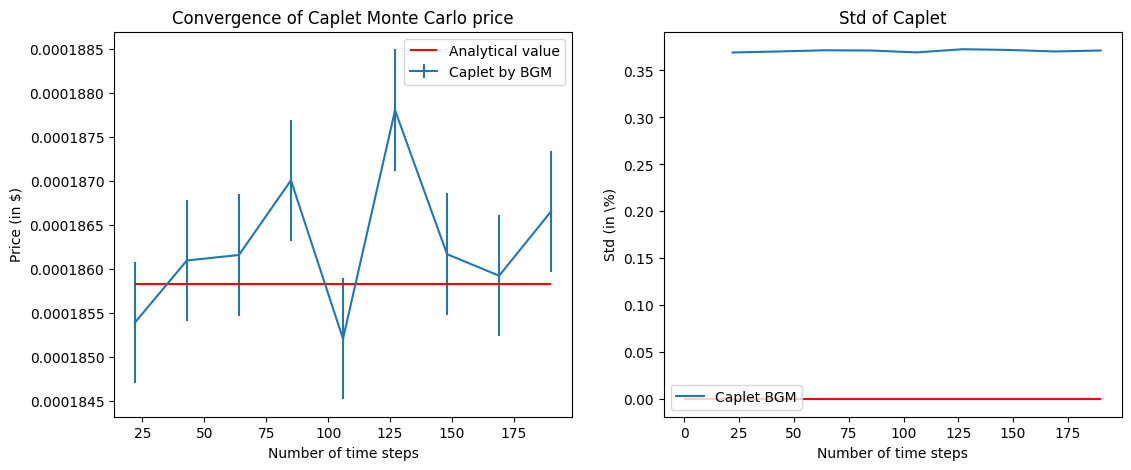

In [ ]:
#print(f'Using parameters: sigma = {sigma:.2f}, T0 = {T0:.2f} years, T1 = {T1:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))

ax[0].errorbar(timeStepsVec, MC_Caplet_PT0,  yerr =MC_Caplet_PT0_std, label = f'Caplet by BGM')
ax[1].plot(timeStepsVec, 100*MC_Caplet_PT0_std/_bsmCaplet, label = "Caplet BGM")

ax[0].set_title('Convergence of Caplet Monte Carlo price')
ax[0].set_xlabel('Number of time steps')
ax[0].hlines(xmin = timeStepsVec[0], xmax = timeStepsVec[-1], y =_bsmCaplet , color = 'red', label='Analytical value')
ax[0].legend()
ax[0].set_ylabel(r'Price (in \$)')
ax[1].set_title('Std of Caplet')
ax[1].set_xlabel('Number of time steps')
ax[1].set_ylabel(r'Std (in \%)')
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = timeStepsVec[-1])
ax[1].legend()
fig.show()

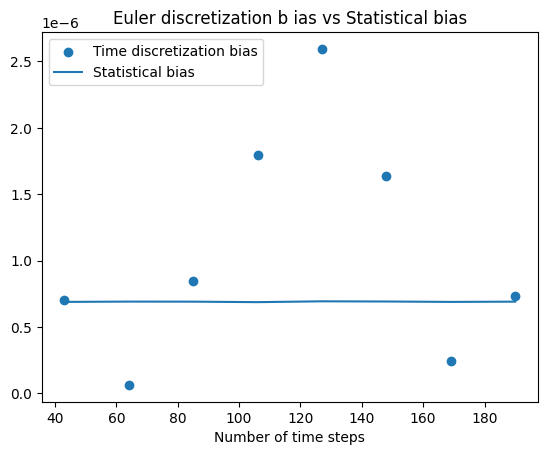

In [ ]:
# The time discretization bias
discrBias = abs(np.diff(MC_Caplet_PT0))
# Statistical bias
MCbias = MC_Caplet_PT0_std[1:]
fig,ax = plt.subplots(1,1)
ax.set_title('Euler discretization b ias vs Statistical bias')
ax.set_xlabel('Number of time steps')
ax.scatter(timeStepsVec[1:], discrBias, label = 'Time discretization bias')
ax.plot(timeStepsVec[1:], MCbias, label = 'Statistical bias')
ax.legend()

Clearly, the noise for $M = 10^6$ paths comes from the statistical source, no time discretization bias

Even substepping of $5$ should be enough

# Check caplet price invariance to numeraire change in BGM process

In [ ]:
N = 2 # number of underlying times
# Numeraire is the bond expiring at maturity of forward rate with this index
numeraireIndex = 0 # The numeraire can only take a value between [0,NFR]
NFR, Kj, timesArray, Pcurve, taus, initialForwardRates = computeInitialConditions(N)


subStepping = 5 # Number of substeps between any 2 underlying times

dt = timesArray[1] - timesArray[0]
edt = dt/subStepping # Substepping dt
timeSteps = int(timesArray[-1]/edt)+1

Npaths = int(1e5) # Number of paths to be generated via the BGM process

In [ ]:
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)

In [ ]:
BGM.run()

In [ ]:
_bgmCaplet = BGMCaplet(timesArray, 0)

In [ ]:
_bgmCapletPrice,_ = _bgmCaplet.price(BGM, K, Pcurve)
#Compute the analytical value of a caplet expiring at T0 based on a FRA between T0 and T1
_bsmCaplet = BSMcaplet(f0 = initialForwardRates[0], K = K, T2 = timesArray[1], P2 = Pcurve[1], T1 = timesArray[0], sigma = d)
print(f'The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is {100*(_bgmCapletPrice-_bsmCaplet)/_bsmCaplet:.3f} %')

The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is 0.498 %


The implementation thus respects Price invariance with respect to numeraire change

#Testing the BGM model by pricing Swaptions

In [ ]:

class BGMSwaption(BGMProduct):
    """
    The time of expiry for the swaption is the start of the swap date
    """
    def __init__(self,underlyingTimes, index):
        self.underlyingTimes = underlyingTimes
        self.I = False # Signal to terminate
        self.index = index
        self.currentTime = 0

    def getUnderlyingTimes(self):
        return self.underlyingTimes

    def getEvolutionTimes(self,index):
        return self.underlyingTimes[index]

    def reset():
        pass

    def doNextStep(self, f):

        pass

    def price(self, BGM, swaptionStrike, B0):

        evolutionIndices = BGM.getEvolutionIndices()
        productIndex = evolutionIndices[self.index]

        _fs = BGM.forwardRates[:,:,productIndex-1]
        _P = np.ones((N, Npaths))
        for i in range(1,N):
            for j in range(i):
                _P[i] *= (1/(1+_fs[j]*taus[j]))

        B = np.sum(_P[1:]*taus[0], axis = 0)

        # Compute the Swap rate out of BGM paths
        X1 = 0
        for i in range(N-1):
            X1 += _fs[i,:]*taus[i]*_P[i+1,:]/B

        return np.mean(np.maximum(X1-swaptionStrike,0))*B0

In [ ]:
N = 3 # number of underlying times
# Numeraire is the bond expiring at maturity of forward rate with this index
numeraireIndex = 1 # The numeraire can only take a value between [0,NFR]

NFR, Kj, timesArray, Pcurve, taus, initialForwardRates = computeInitialConditions(N)

subStepping = 5 # Number of substeps between any 2 underlying times

dt = timesArray[1] - timesArray[0]
edt = dt/subStepping # Substepping dt
timeSteps = int(timesArray[-1]/edt)+1

Npaths = int(1e5) # Number of paths to be generated via the BGM process

In [ ]:
print(f'timesteps: {timeSteps}, Npaths: {Npaths}')

timesteps: 111, Npaths: 100000


In [ ]:
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)

In [ ]:
BGM.run()

In [ ]:
KSR = 0.05 #Strike of swap rate

In [ ]:
_bgmSwaption =BGMSwaption(timesArray, 0)

In [ ]:
B0 = np.sum(Pcurve[1:]*taus, axis = 0) # Computing annuity of Swaption at T = 0
#Have to compute initial Swap rate
X0 = (Pcurve[0]-Pcurve[-1])/B0
# Then compute the weights w_l
w = taus[0]*Pcurve[1:]/B0

In [ ]:
_bgmSwaptionPrice = _bgmSwaption.price(BGM, KSR, B0)

In [ ]:
_bgmSwaptionPrice

np.float64(0.002014631313582303)

##Rapid swaption pricing formula

Formula was taken from https://arc.hhs.se/download.aspx?MediumId=190

In [ ]:
#Have to compute initial Swap rate
X0 = (Pcurve[0]-Pcurve[-1])/B0
# Then compute the weights w_l
w = taus[0]*Pcurve[1:]/B0

print(f'Test whether the weights are correctly implemented : {np.sum(w*initialForwardRates) - X0 < 1e-5}')

# Variance of X approximation
_cov =computeForwardRateCovarianceMatrix(timesArray,0,timesArray[0])

_varSR = 0
for i in range(NFR):
    for j in range(NFR):
        _varSR += _cov[i,j]*w[i]*w[j]*initialForwardRates[i]*initialForwardRates[j]/(X0**2)

_sigmaSR = np.sqrt((1/timesArray[0])*_varSR)

print(f'The estimated volatility to be used in BSM swaption formula is {_sigmaSR*100:.3f} %')

Test whether the weights are correctly implemented : True
The estimated volatility to be used in BSM swaption formula is 5.000 %


In [ ]:
def BSMPayerSwaption(X0, K, T1, B, sigma):
    """
    BSM Swaption implementation

    X0 : initial swap rate
    K : strike
    T1: start of swap rate contract
    B : Annuity
    sigma : volatility
    """
    Q = BSMcall(X0, K, T1, 0, 0, 0, sigma)
    return B*Q


In [ ]:
B0*BSMcall(X0, KSR, timesArray[0],0, 0, 0, _sigmaSR)

np.float64(0.0020422745241727254)

In [ ]:
# Getting the BSM swaption price with estimated volatility
_bsmPayerSwaptionPrice = BSMPayerSwaption(X0 = X0, K = KSR, T1 = timesArray[0], B = B0, sigma = _sigmaSR)

In [ ]:
print(f'The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is {100*(_bgmSwaptionPrice-_bsmPayerSwaptionPrice)/_bsmPayerSwaptionPrice:.3f} %')

The discrepancy between Monte Carlo BGM caplet value and Analytical BSM caplet value is -1.354 %


The match is very good given the number of paths used. The estimate is well within the $95\%$ confidence interval

## Pricing a Swap Rate Trigger Swap

In [ ]:
class BGMTriggerSwap(BGMProduct):
    """
    The time of expiry for the swaption is the start of the swap date
    """
    def __init__(self,underlyingTimes, triggerSwap):
        self.underlyingTimes = underlyingTimes
        self.I = False # Signal to terminate
        self.currentTime = 0
        self.triggerSwap = triggerSwap

    def getUnderlyingTimes(self):
        return self.underlyingTimes

    def getEvolutionTimes(self,index):
        return self.underlyingTimes[index]

    def reset():
        pass

    def doNextStep(self, f):

        pass

    def computeRemainingSwapRate(self, BGM, underlyingIndex, refTimeIdx):

        _fs = BGM.forwardRates[: , : ,refTimeIdx]
        _P = np.ones((N, Npaths))

        for i in range(underlyingIndex,N):
            for j in range(i):
                _P[i,:] *= (1/(1+_fs[j,:]*taus[j]))

        B = np.sum(_P[underlyingIndex:,:]*taus[0], axis = 0)

        # Compute the Swap rate out of BGM paths
        X1 = 0
        for i in range(underlyingIndex,N-1):
            X1 += _fs[i,:]*taus[i]*_P[i+1,:]/B

        return X1

    def price(self, BGM):

        # Trigger times as evolution time indices
        triggerStages = BGM.evolutionIndices

        _cash = np.zeros(Npaths)

        nullPathsIndices = []

        for uTidx in range(N-1):

            _triggerRefTime = triggerStages[uTidx]

            _swapRate = self.computeRemainingSwapRate(BGM,  uTidx, _triggerRefTime)

            # Check swap rate against the trigger
            nullPathsIndices.append(np.argwhere(_swapRate > self.triggerSwap))

            # Cash accrues interest before any new payment is made
            # Forward rates indices are First the Forward Rate Index, The Path Index then the Evolution Time Index
            _cash *=  (1 + BGM.forwardRates[uTidx, : ,_triggerRefTime]*taus[0])

            if uTidx > 0:

                # FRA expires and payment is made
                _cash += (BGM.forwardRates[uTidx, :, _triggerRefTime]-K)*taus[0]

        # Knock out all paths that crossed the trigger
        _cash[np.concat(nullPathsIndices)] = 0

        return np.mean(_cash), np.std(_cash)/np.sqrt(BGM.Npaths)

In [ ]:
# Volatility term structure
# Make a,b = 0 such that volatility is constant
a = 0
b = 0
c = 0.44 # c has to be non 0 such that covariance matrix can still be computed
d = 0.05 # This is the volatility chosen, 5%

# Instantaneous forward rate correlation parameter
beta = 0.1
# Discount curve
PCurveFun = lambda x : np.exp(-0.05*x)
Tstart = 10 # The maturity of the first forward rate simulated
cashflowInterval = 0.5 # The period (estimated in years) between separate cash payments

In [ ]:
N = 3 # number of underlying times
# Numeraire is the bond expiring at maturity of forward rate with this index
numeraireIndex = 1 # The numeraire can only take a value between [0,NFR]

NFR, Kj, timesArray, Pcurve, taus, initialForwardRates = computeInitialConditions(N)

subStepping = 5 # Number of substeps between any 2 underlying times

dt = timesArray[1] - timesArray[0]
edt = dt/subStepping # Substepping dt
timeSteps = int(timesArray[-1]/edt)+1

Npaths = int(1e5) # Number of paths to be generated via the BGM process

### Test price sensitivity to $\beta = 0$ and $\beta = 0.1$

In [ ]:
beta = 0.1

In [ ]:
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)

In [ ]:
BGM.run()

In [ ]:
# Swap Trigger R
R = .065
K = 0.055 # strike of swap
_bgmTriggerSwap = BGMTriggerSwap(timesArray, R)

In [ ]:
_bgmTriggerSwap.price(BGM)

(np.float64(-0.002181410304014975), np.float64(1.3028912529593785e-05))

Change $\beta =0$

In [ ]:
beta = 0.0001
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)
BGM.run()

In [ ]:
# Swap Trigger R
R = .065
K = 0.055 # strike of swap
_bgmTriggerSwap = BGMTriggerSwap(timesArray, R)


In [ ]:
_bgmTriggerSwap.price(BGM)

(np.float64(-0.0021628686859956397), np.float64(1.311600158524338e-05))

Price of trigger swap drops upon a diminishing correlation

## Return to a,b,c,d volatility structure and test the beta sensitivity

In [ ]:
# Volatility term structure
# Make a,b = 0 such that volatility is constant
a = 0.05
b = 0.09
c = 0.44 # c has to be non 0 such that covariance matrix can still be computed
d = 0.05 # This is the volatility chosen, 5%

# Discount curve
PCurveFun = lambda x : np.exp(-0.05*x)
Tstart = 10 # The maturity of the first forward rate simulated
cashflowInterval = 0.5 # The period (estimated in years) between separate cash payments

In [ ]:
beta = 0.1
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)
BGM.run()

In [ ]:
# Swap Trigger R
R = .065
K = 0.055 # strike of swap
_bgmTriggerSwap = BGMTriggerSwap(timesArray, R)


In [ ]:
_bgmTriggerSwap.price(BGM)

(np.float64(-0.0025574981181280083), np.float64(2.5851043479746445e-05))

Change to $\beta = 0$

In [ ]:
beta = 0.0001
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)
BGM.run()

In [ ]:
# Swap Trigger R
R = .065
K = 0.055 # strike of swap
_bgmTriggerSwap = BGMTriggerSwap(timesArray, R)


In [ ]:
_bgmTriggerSwap.price(BGM)

(np.float64(-0.0025599935667785074), np.float64(2.571756462247886e-05))

Upon switching to variable volatilities, the beta sensitivity lost its impact on the trigger swap

## Test whether a 1% increase in volatility impact the trigger swap price

In [ ]:
Kj = np.ones(NFR)*1.01

In [ ]:
# Volatility term structure
# Make a,b = 0 such that volatility is constant
a = 0.05
b = 0.09
c = 0.44 # c has to be non 0 such that covariance matrix can still be computed
d = 0.05 # This is the volatility chosen, 5%

# Discount curve
PCurveFun = lambda x : np.exp(-0.05*x)
Tstart = 10 # The maturity of the first forward rate simulated
cashflowInterval = 0.5 # The period (estimated in years) between separate cash payments

In [ ]:
beta = 0.1
BGM = BGMEngine(
    Npaths = Npaths,
    underlyingTimes = timesArray,
    randomNumberGenerator = np.random.normal,
    subStepping = subStepping,
    initialForwardRates = initialForwardRates,
    numeraireIndex = numeraireIndex,
)
BGM.run()

In [ ]:
# Swap Trigger R
R = .065
K = 0.055 # strike of swap
_bgmTriggerSwap = BGMTriggerSwap(timesArray, R)


In [ ]:
_bgmTriggerSwap.price(BGM)

(np.float64(-0.0025520573393031493), np.float64(2.606416444475725e-05))

There seems to be no significant change